In [6]:
from matplotlib import pyplot as plt
import numpy as np
import qiskit
import qiskit_aer
import warnings
from itertools import product

# Exercise 11: Preparing the state $\ket{\psi(a,b)}$

Trial state:

$$
    \ket{\psi(a,b)} = \text{exp}\left(ia(\hat{\sigma}_z^{(1)}+\hat{\sigma}_z^{(2)})\right)\text{exp}\left(ib(\hat{\sigma}_z^{(1)}\hat{\sigma}_x^{(2)}+\hat{\sigma}_x^{(1)}\hat{\sigma}_z^{(2)})\right)\ket{00}
$$

Decomposing the gates:

$$
    \text{exp}\left(ia(\hat{\sigma}_z^{(1)}+\hat{\sigma}_z^{(2)})\right) = \text{exp}\left(ia\hat{\sigma}_z^{(1)}\right)\text{exp}\left(ia\hat{\sigma}_z^{(2)}\right) = \hat{R}_z^{(1)}(-2a)\hat{R}_z^{(2)}(-2a)
$$

and

$$
    \text{exp}\left(ib(\hat{\sigma}_z^{(1)}\hat{\sigma}_x^{(2)}+\hat{\sigma}_x^{(1)}\hat{\sigma}_z^{(2)})\right) = \text{exp}\left(ib\hat{\sigma}_z^{(1)}\hat{\sigma}_x^{(2)}\right)\text{exp}\left(\hat{\sigma}_x^{(1)}\hat{\sigma}_z^{(2)}\right) = \hat{U}_{\text{SWAP}}\hat{R}_{XZ}(-2b)\hat{U}_{\text{SWAP}}\hat{R}_{XZ}(-2b)
$$

In [40]:
import qiskit.quantum_info
import qiskit_aer.primitives


def trial_state_circuit(a:float,b:float) -> qiskit.circuit.QuantumCircuit:
    """Creates a circuit that gives the trial state from exercise 11."""
    circ = qiskit.QuantumCircuit(2)

    # applying the gates
    circ.rzx(theta=-2*b,qubit1=0,qubit2=1)
    circ.rzx(theta=-2*b,qubit1=1,qubit2=0)
    circ.rz(phi=-2*a,qubit=0)
    circ.rz(phi=-2*a,qubit=1)

    return circ

# constructing the observable
hamiltonian = qiskit.quantum_info.SparsePauliOp(data=("XZ","ZX"),coeffs=(-1,-1))

# estimator
sim = qiskit_aer.primitives.Estimator()

# Exercise 12: Optimizing $a$ and $b$ using a grid search

In [24]:
a_axis = np.linspace(start=0,stop=np.pi,num=100)
b_axis = np.linspace(start=0,stop=np.pi,num=100)

In [28]:
# grid search to find the optimal parameters a,b
exp_values = sim.run(
    circuits = [trial_state_circuit(a,b) for a,b in product(a_axis,b_axis)],
    observables = [hamiltonian for a,b in product(a_axis,b_axis)],
    shots=400
).result().values

The minimum expectation value is -2.000. It is achieved for:
  a = 0.762 = pi * 0.242
  b = 0.793 = pi * 0.253


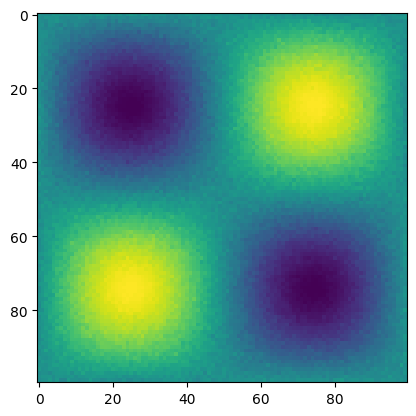

In [68]:
# finding the best parameters
iMin = np.argmin(exp_values)
a_index = iMin // a_axis.shape[0]
b_index = iMin % b_axis.shape[0]

plt.imshow(np.array(exp_values).reshape((a_axis.shape[0],b_axis.shape[0])))
plt.savefig("plots/ex12.png",dpi=800)

print("The minimum expectation value is {:.3f}. It is achieved for:\n  a = {:.3f} = pi * {:.3f}\n  b = {:.3f} = pi * {:.3f}".format(exp_values[iMin],a_axis[a_index],a_axis[a_index]/np.pi,b_axis[b_index],b_axis[b_index]/np.pi))

# Exercise 13: Checking if we have found the correct eigenvector

In [65]:
# getting the ground state
state_sim = qiskit_aer.backends.AerSimulator(method="statevector")
optimal_circuit = trial_state_circuit(a_axis[a_index],b_axis[b_index])
optimal_circuit.save_statevector()
ground_state = np.array(state_sim.run(optimal_circuit).result().get_statevector())

# getting the analytical solution for the ground state
state0 = np.array([1,0])
state1 = np.array([0,1])
ground_state_exact = (np.kron(state1,state0-state1) + np.kron(state0,state0+state1)) / 2

# finding a global phase between simulated and exact solution, if there is any
phase = np.sum(ground_state.conj() * ground_state_exact)

print("Our simulation and the exact solution have a distance of {:.3e} and a relative phase of {:.3}".format(np.sqrt(np.sum((ground_state * phase - ground_state_exact) * (ground_state * phase - ground_state_exact).conj()).real),phase))

Our simulation and the exact solution have a distance of 3.547e-02 and a relative phase of (-0.000377-0.999j)


# Exercise 14: Adding noise

In [60]:
# defining a noisy simulator
p = 0.2
gamma = 0.1
GAD = qiskit_aer.noise.amplitude_damping_error(gamma,p)
tensorGAD = GAD.tensor(GAD)
noise = qiskit_aer.noise.NoiseModel()
noise.add_all_qubit_quantum_error(error=tensorGAD,instructions=["rzx"])
noise.add_quantum_error(error=GAD,qubits=[0],instructions=["rz"])
sim_noisy = qiskit_aer.primitives.Estimator(backend_options={"noise_model":noise})

In [61]:
# grid search to find the optimal parameters a,b
exp_values_noisy = sim_noisy.run(
    circuits = [trial_state_circuit(a,b) for a,b in product(a_axis,b_axis)],
    observables = [hamiltonian for a,b in product(a_axis,b_axis)],
    shots=400
).result().values

The minimum expectation value is -1.520. It is achieved for:
  a = 2.443 = pi * 0.778
  b = 2.380 = pi * 0.758


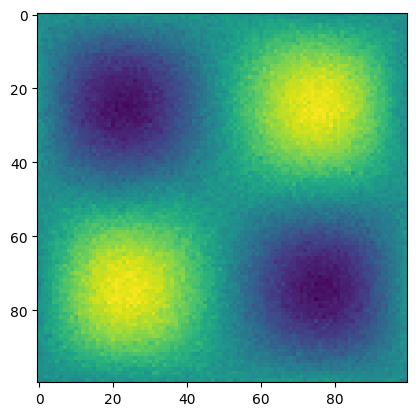

In [67]:
# finding the best parameters
iMin = np.argmin(exp_values_noisy)
a_index_noisy = iMin // a_axis.shape[0]
b_index_noisy = iMin % b_axis.shape[0]

plt.imshow(np.array(exp_values_noisy).reshape((a_axis.shape[0],b_axis.shape[0])))
plt.savefig("plots/ex14.png",dpi=800)

print("The minimum expectation value is {:.3f}. It is achieved for:\n  a = {:.3f} = pi * {:.3f}\n  b = {:.3f} = pi * {:.3f}".format(exp_values_noisy[iMin],a_axis[a_index_noisy],a_axis[a_index_noisy]/np.pi,b_axis[b_index_noisy],b_axis[b_index_noisy]/np.pi))

In [70]:
# getting the ground state
optimal_noisy_circuit = trial_state_circuit(a_axis[a_index_noisy],b_axis[b_index_noisy])
optimal_noisy_circuit.save_statevector()
ground_state_noisy = np.array(state_sim.run(optimal_noisy_circuit).result().get_statevector())

# finding a global phase between noisy and exact solution, if there is any
phase_noisy = np.sum(ground_state_noisy.conj() * ground_state_exact)

print("Our noisy simulation and the exact solution have a distance of {:.3e} and a relative phase of {:.3}".format(np.sqrt(np.sum((ground_state_noisy * phase_noisy - ground_state_exact) * (ground_state_noisy * phase_noisy - ground_state_exact).conj()).real),phase_noisy))

Our noisy simulation and the exact solution have a distance of 1.274e-01 and a relative phase of (0.00413+0.992j)
